In this notebook, we will fine-tune gpt-2 model for adapting it to customer conversation sentiment classification.

If you didn't install the required packages before, you can with the commented out lines below. Otherwise, you will get errors at the first import.

In [1]:
#!pip install torch numpy transformers datasets tiktoken wandb tqdm matplotlib seaborn scipy scikit-learn
#!pip install accelerate
#!pip install transformers torch -U

In [2]:
import pickle
import datasets
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import GPT2ForSequenceClassification
from transformers import Trainer, TrainingArguments
from models.evaluate_fine_tuned import evaluate_on_test
from sklearn.metrics import confusion_matrix

/home/eren/anaconda3/envs/DI725_assignment1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will initialize the Weights & Biases project now. If you are not logged in to your wandb account, in this step you should enter your wandb credentials.

In [3]:
wandb.init(
    project="DI725_assignment_1_2389088_fine_tune"
)
config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: erennarin-92 (erennarin-92-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


We should load the tokenized data that is created at [2_preprocess.ipynb](2_preprocess.ipynb) first. Dataset format is suitable for training a model with huggingface's transformer library.

In [4]:
tokenized_datasets = datasets.load_from_disk(f"../data/final/train-val.hf")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 776
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 194
    })
})

The dataset contains train and validation datasets only. Test dataset hasn't been tokenized yet.

At next step, we create a GPT2 Sequence Classification model with pretrained weights. We can see the structure of the model below.

In [5]:
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)
model

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=3, bias=False)
)

We define our training arguments and start training process here. Different arguments have been tested during development process and these values are from the best performed configuration.

In [6]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    num_train_epochs=5,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"]
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss
500,2.814300
1000,1.396900
1500,1.000900
2000,0.777700
2500,0.602000
3000,0.472600
3500,0.302400


TrainOutput(global_step=3880, training_loss=0.9829104629988523, metrics={'train_runtime': 585.3053, 'train_samples_per_second': 6.629, 'train_steps_per_second': 6.629, 'total_flos': 2027681092730880.0, 'train_loss': 0.9829104629988523, 'epoch': 5.0})

This training took ~10 minutes on RTX 3080 Laptop GPU. Training metrics can be investigated on W&B too. Now we can start to evaluate our fine-tuned model.

In [7]:
test_path = "../data/final/test.csv"
df_test = pd.read_csv(test_path)

preds, labels = evaluate_on_test(model, df_test)

Prediction: neutral - Label: negative
Prediction: neutral - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: positive
Prediction: positive - Label: positive
Prediction: positive - Label: positive
Prediction: neutral - Label: positive
Prediction: positive - Label: positive
Prediction: neutral - Label: positive
Prediction:

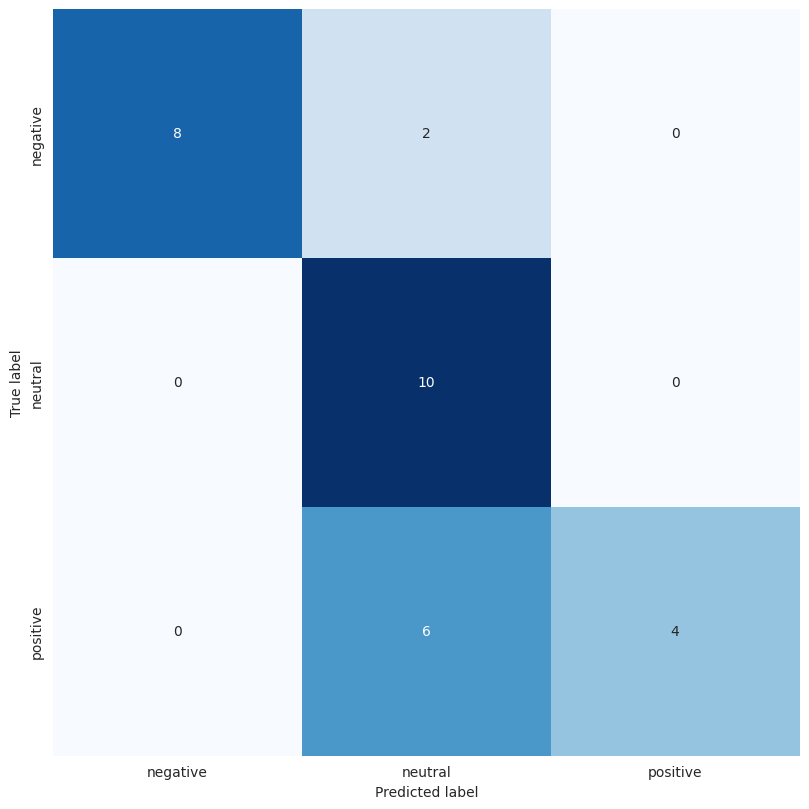

In [8]:
classes = ["negative", "neutral", "positive"]
cm = confusion_matrix(labels, preds, labels=classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False, xticklabels=classes, yticklabels=classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [9]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds, target_names=classes))

              precision    recall  f1-score   support

    negative       1.00      0.80      0.89        10
     neutral       0.56      1.00      0.71        10
    positive       1.00      0.40      0.57        10

    accuracy                           0.73        30
   macro avg       0.85      0.73      0.72        30
weighted avg       0.85      0.73      0.72        30



In this training, the model has performed with 73% accuracy on test dataset. As we can see on confusion matrix, the model classified the neutral and negative inputs well, however it failed to classify positive examples correctly. This is expected, because our dataset is a biased one. There are very few positive examples in both train and test sets. To increase performance on minority classes, we can collect more data or augment data with new samples from minority classes.

This fine-tuned model performed better than the model that we trained from scratch in [3_nanoGPT_from_scratch.ipynb] (3_nanoGPT_from_scratch.ipynb). GPT2 has trained with a vast dataset on excessive hardware resources. If the resources are limited, fine-tuning pre-trained model for a specific task is usually the best option.

In [10]:
model_path = '../models/4_gpt2_sentiment_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)